In [1]:
# import packages

import itertools
import cv2
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from glob import glob

In [2]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# upload kaggle json file
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"engalaasamir","key":"783070959d5b75b4a03ad9767502d215"}'}

In [4]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.75G/1.76G [00:13<00:00, 114MB/s]
100% 1.76G/1.76G [00:13<00:00, 144MB/s]


In [6]:
# unzip dataset
from zipfile import ZipFile
file_name='/content/lung-and-colon-cancer-histopathological-images.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [7]:
# Copying the folders into a single folder
!mkdir ./LungColon

print('Copying files...')
!cp -R /content/lung_colon_image_set/colon_image_sets/* ./LungColon
!cp -R /content/lung_colon_image_set/lung_image_sets/* ./LungColon
print('All files copied successfully!')

Copying files...
All files copied successfully!


In [8]:
folders = glob('./LungColon' + '/*')
print('New Paths: ', folders)

IMAGE_FILES = glob('./LungColon' + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))

New Paths:  ['./LungColon/lung_scc', './LungColon/lung_aca', './LungColon/colon_n', './LungColon/lung_n', './LungColon/colon_aca']
Images Count:  25000


In [9]:
# data augmentation
data_dir = '/content/LungColon'

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.15)

BATCH_SIZE = 64

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 224

training = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 101)

validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 101)

Found 21250 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.


In [10]:
# build model and using pre-trained model
ptm = PretrainedModel(
    input_shape=(X, Y, 3),
    weights='imagenet',
    include_top=False)

ptm.trainable = False

K = len(folders)

x = GlobalAveragePooling2D()(ptm.output)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(.2)(x)

x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(.2)(x)

y = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=y);

258088960/258076736 [==============================] - 2s 0us/step


In [11]:
# model compile
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [12]:
# model check points
es = EarlyStopping(monitor='val_loss', patience=5)
os.mkdir('/content/check_point')
cp = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/check_point/best_weight.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [13]:
# training
history = model.fit(
    training,
    validation_data=validation,
    epochs=25,
    callbacks=[es,cp])

Epoch 1/25
333/333 [==============================] - 681s 2s/step - loss: 0.6217 - accuracy: 0.7613 - val_loss: 0.1974 - val_accuracy: 0.9315
Epoch 2/25
333/333 [==============================] - 630s 2s/step - loss: 0.2118 - accuracy: 0.9256 - val_loss: 0.1192 - val_accuracy: 0.9560
Epoch 3/25
333/333 [==============================] - 631s 2s/step - loss: 0.1472 - accuracy: 0.9487 - val_loss: 0.0916 - val_accuracy: 0.9677
Epoch 4/25
333/333 [==============================] - 629s 2s/step - loss: 0.1154 - accuracy: 0.9580 - val_loss: 0.1079 - val_accuracy: 0.9493
Epoch 5/25
333/333 [==============================] - 629s 2s/step - loss: 0.0928 - accuracy: 0.9655 - val_loss: 0.0508 - val_accuracy: 0.9795
Epoch 6/25
333/333 [==============================] - 627s 2s/step - loss: 0.0898 - accuracy: 0.9663 - val_loss: 0.0513 - val_accuracy: 0.9824
Epoch 7/25
333/333 [==============================] - 625s 2s/step - loss: 0.0610 - accuracy: 0.9776 - val_loss: 0.0695 - val_accuracy: 0.9739

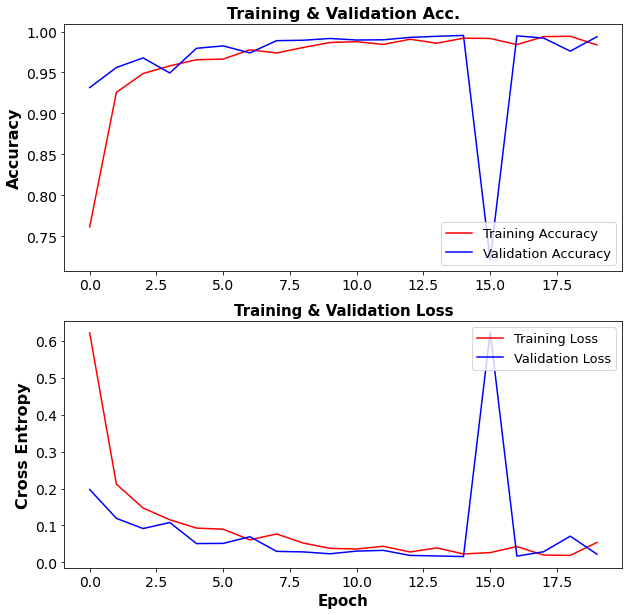

In [14]:
# Visualize results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

In [15]:
from sklearn.metrics import classification_report

Y_pred = model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       750
           1       1.00      1.00      1.00       750
           2       1.00      0.98      0.99       750
           3       1.00      1.00      1.00       750
           4       0.98      1.00      0.99       750

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750



In [38]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(validation.classes, y_pred,pos_label=4)

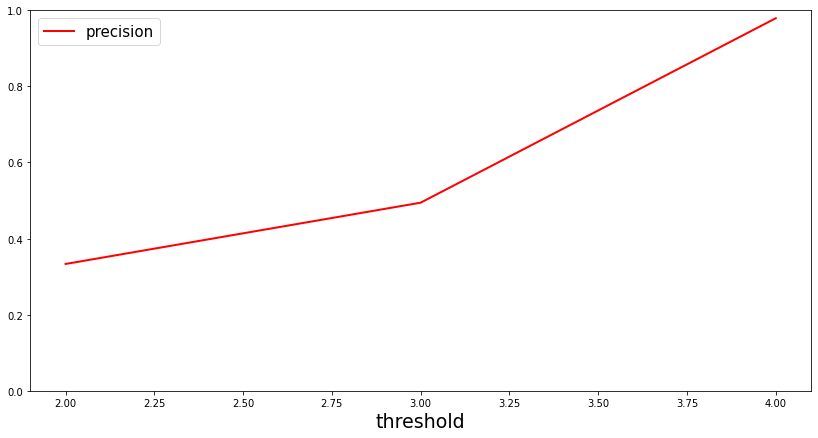

In [22]:
def plot_precision(precision, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=2)
    plt.xlabel("threshold", fontsize=19)
    plt.legend( fontsize=15)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision(precision, threshold)
plt.show()

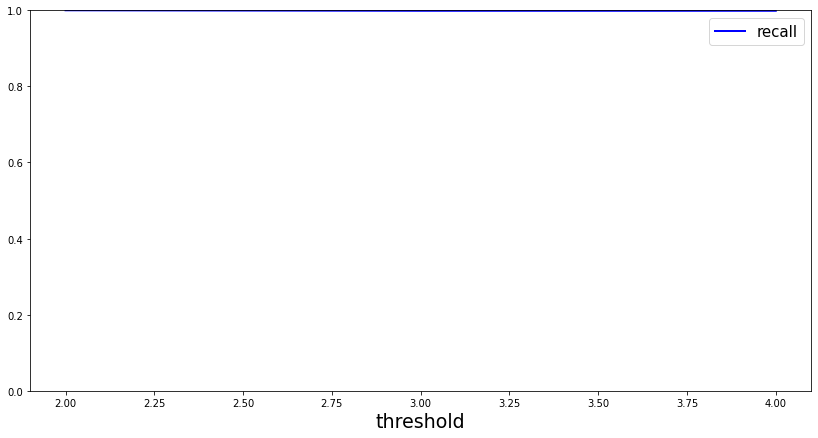

In [40]:
def plot_recall( recall, threshold):
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=2)
    plt.xlabel("threshold", fontsize=19)
    plt.legend( fontsize=15)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_recall( recall, threshold)
plt.show()

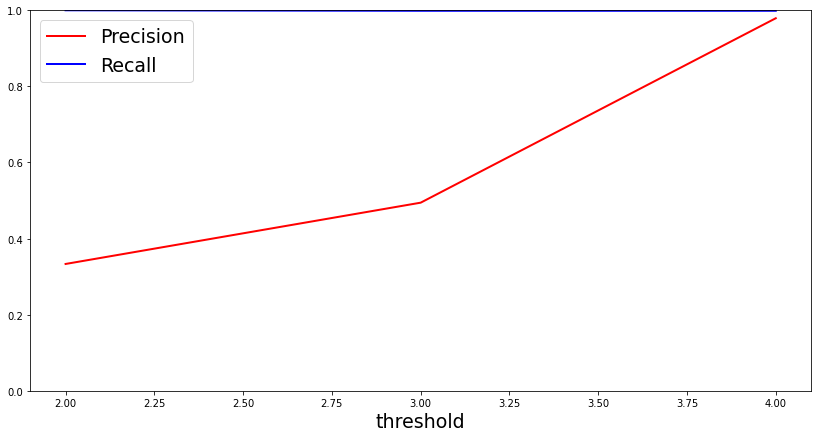

In [39]:
def plot_precision_and_recall(precision,recall,threshold):
    plt.plot(threshold, precision[:-1], "r-", label="Precision", linewidth=2)
    plt.plot(threshold, recall[:-1], "b", label="Recall", linewidth=2)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision,recall,threshold)
plt.show()

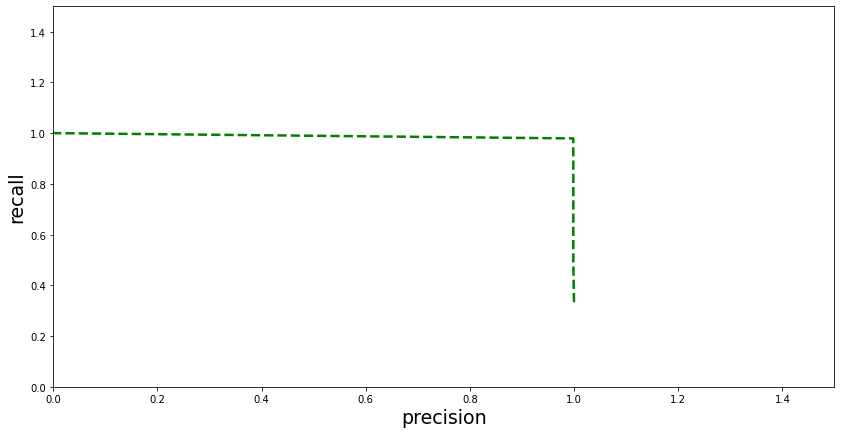

In [41]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

In [52]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(validation.classes, y_pred,pos_label=4)

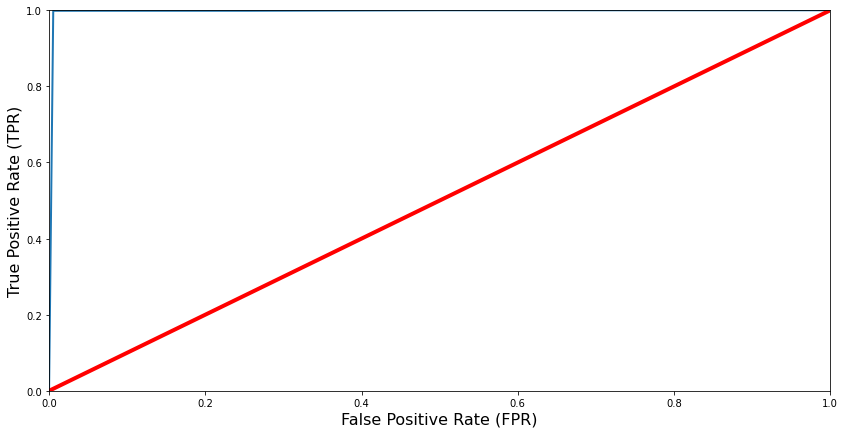

In [53]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

Normalized confusion matrix


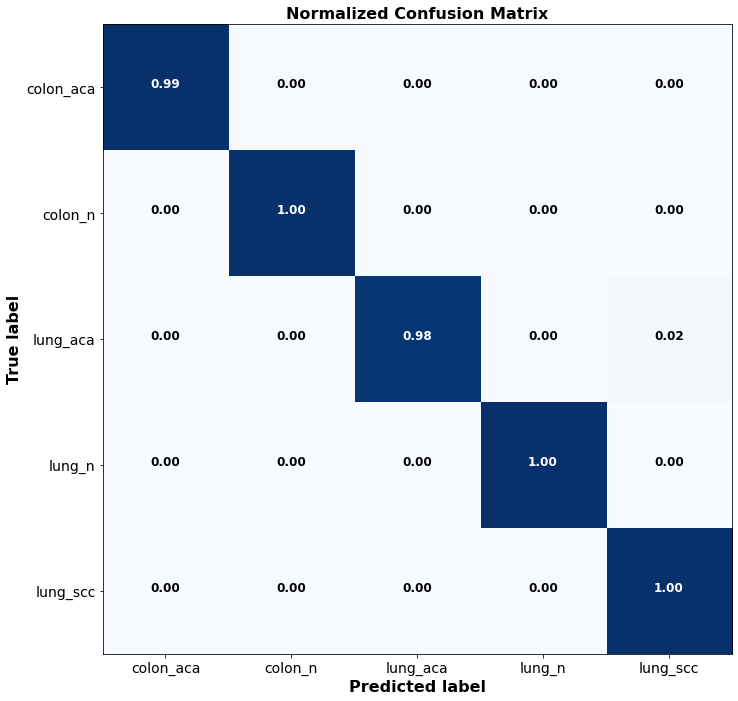

In [54]:
# confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()